In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
import pandas as pd
from sqlalchemy import create_engine

# Paramètres pour la connexion à SQL Server
server = 'DIRAR'
database = 'DATA WAREHOUSE'
username = 'sa'
password = 'azerty123'

# Création du moteur SQLAlchemy pour SQL Server
engine = create_engine(
    f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
)

# Charger les tables nécessaires dans des DataFrames pandas
dim_admission = pd.read_sql("SELECT * FROM dim_admission", engine)
dim_patients = pd.read_sql("SELECT * FROM dim_patients", engine)
dim_doctor = pd.read_sql("SELECT * FROM dim_doctor", engine)
dim_reclamation = pd.read_sql("SELECT * FROM dim_reclamation", engine)
dim_temps = pd.read_sql("SELECT * FROM dim_temps", engine)
satisfaction_fact = pd.read_sql("SELECT * FROM satisfaction_fact", engine)

# Affichage de quelques lignes pour vérifier
print(dim_admission.head())
print(dim_patients.head())

   hadm_id admission_type         admission_location        discharge_location
0   100375      EMERGENCY  TRANSFER FROM HOSP/EXTRAM                       SNF
1   100969      EMERGENCY       EMERGENCY ROOM ADMIT              DEAD/EXPIRED
2   101361      EMERGENCY  TRANSFER FROM HOSP/EXTRAM  REHAB/DISTINCT PART HOSP
3   103379      EMERGENCY       EMERGENCY ROOM ADMIT          HOME HEALTH CARE
4   103770      EMERGENCY       EMERGENCY ROOM ADMIT  REHAB/DISTINCT PART HOSP
   subject_id insurance language  religion marital_status  \
0       10006  Medicare           CATHOLIC      SEPARATED   
1       10011   Private           CATHOLIC         SINGLE   
2       10013  Medicare           CATHOLIC                  
3       10017  Medicare           CATHOLIC       DIVORCED   
4       10019  Medicare           CATHOLIC       DIVORCED   

                ethnicity  
0  BLACK/AFRICAN AMERICAN  
1   UNKNOWN/NOT SPECIFIED  
2   UNKNOWN/NOT SPECIFIED  
3                   WHITE  
4                  

In [8]:
# Load the satisfaction_fact and dim_temps tables
satisfaction_fact = pd.read_sql("SELECT Reclamation_ID, Satisfaction_Impact, Resolution_Duration_Days, temps_ID FROM satisfaction_fact", engine)
dim_temps = pd.read_sql("SELECT temps_ID, DateTransaction FROM dim_temps", engine)

# Merge the two DataFrames on 'temps_ID'
merged_df_ts = pd.merge(satisfaction_fact, dim_temps, on='temps_ID', how='inner')

# Convert 'DateTransaction' to datetime objects
merged_df_ts['DateTransaction'] = pd.to_datetime(merged_df_ts['DateTransaction'])

# Set 'DateTransaction' as the index
merged_df_ts.set_index('DateTransaction', inplace=True)

# Sort the index chronologically
merged_df_ts.sort_index(inplace=True)

print("First few rows of the time series data:")
print(merged_df_ts.head())

First few rows of the time series data:
                Reclamation_ID  Satisfaction_Impact  Resolution_Duration_Days  \
DateTransaction                                                                 
1955-10-06                rec3                    4                         9   
1956-08-22                rec2                    1                         3   
1959-03-06               rec11                    3                        18   
1959-05-05               rec20                    1                        28   
1959-11-24               rec18                    3                        20   

                 temps_ID  
DateTransaction            
1955-10-06              3  
1956-08-22              2  
1959-03-06             11  
1959-05-05             20  
1959-11-24             18  


C:\Users\bdrdi\AppData\Local\Temp\ipykernel_31472\1444047959.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = merged_df_ts[['Satisfaction_Impact', 'Resolution_Duration_Days']].resample('M').mean()


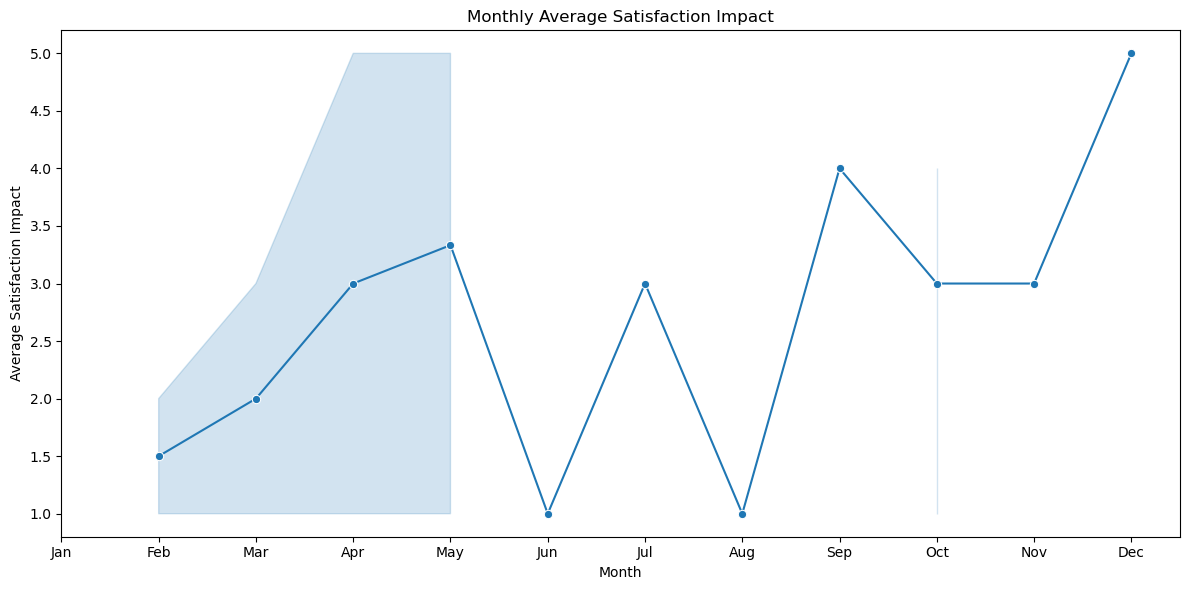

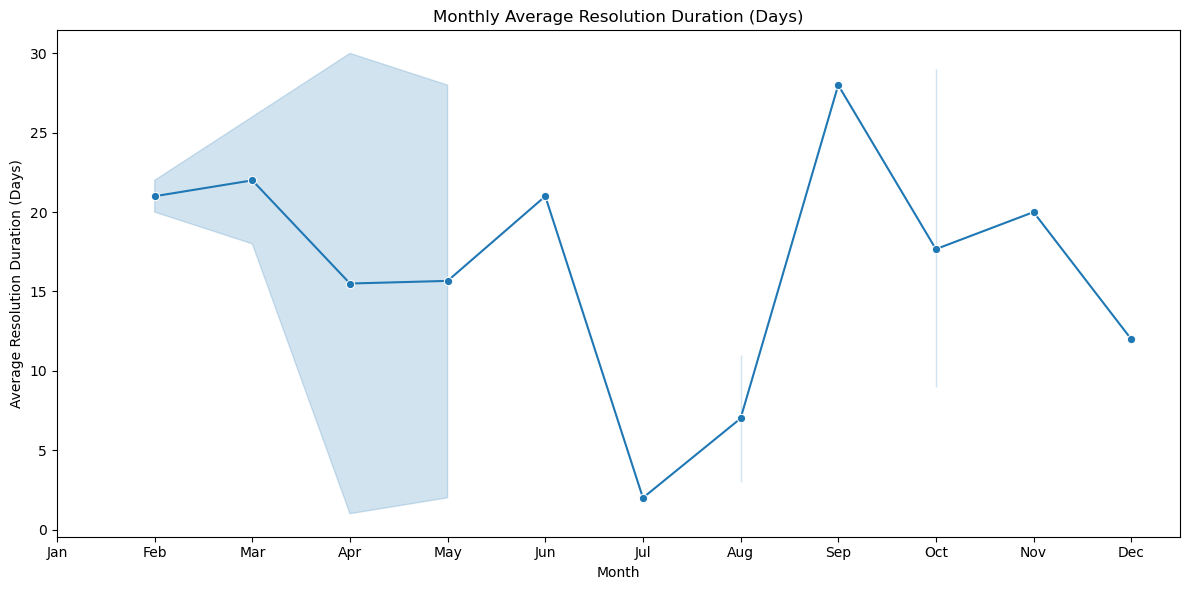

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'DateTransaction' is the index and is in datetime format
if not isinstance(merged_df_ts.index, pd.DatetimeIndex):
    merged_df_ts['DateTransaction'] = pd.to_datetime(merged_df_ts['DateTransaction'])
    merged_df_ts.set_index('DateTransaction', inplace=True)
    merged_df_ts.sort_index(inplace=True)

# Resample to monthly frequency and calculate the mean
monthly_data = merged_df_ts[['Satisfaction_Impact', 'Resolution_Duration_Days']].resample('M').mean()

# Extract the month number from the index for sorting purposes
monthly_data['Month_Number'] = monthly_data.index.month

# Order the months for plotting
month_order = list(range(1, 13))  # Months as numbers for sorting
monthly_data['Month_Number'] = pd.Categorical(monthly_data['Month_Number'], categories=month_order, ordered=True)

# Line plot for Satisfaction Impact by Month
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month_Number', y='Satisfaction_Impact', data=monthly_data, marker='o')
plt.title('Monthly Average Satisfaction Impact')
plt.xlabel('Month')
plt.ylabel('Average Satisfaction Impact')
plt.xticks(rotation=0)  # Keep x-ticks horizontal
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

# Line plot for Resolution Duration by Month
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month_Number', y='Resolution_Duration_Days', data=monthly_data, marker='o')
plt.title('Monthly Average Resolution Duration (Days)')
plt.xlabel('Month')
plt.ylabel('Average Resolution Duration (Days)')
plt.xticks(rotation=0)  # Keep x-ticks horizontal
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()